3: VAE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# take a stratified subset of the training data, keeping only 5000 samples, with 500 samples per class
train_targets = train_dataset.targets
train_idx, _ = train_test_split(range(len(train_targets)), train_size=20000, stratify=train_targets)
train_dataset = torch.utils.data.Subset(train_dataset, train_idx)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")  # for gpu usage

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=200):
        super(ConvVAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (batch_size, 32, 14, 14)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (batch_size, 64, 7, 7)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (batch_size, 128, 4, 4)
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=2)  # (batch_size, 512, 1, 1)
        )

        # Latent space
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 128)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=2),  # (batch_size, 128, 2, 2)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 128, 4, 4)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # (batch_size, 64, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 32, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 1, 28, 28)
        )

    def reparameterize(self, mu, logvar):
        sigma = torch.exp(0.5*logvar)
        epsilon = torch.randn_like(sigma)
        return mu + sigma * epsilon

    def encode(self, x):
        x = self.encoder(x)
        # add average pooling
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        z = self.fc_decode(z)
        z = z.view(z.size(0), 128, 1, 1)
        z = self.decoder(z)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


In [ ]:
def get_class_samples(dataset):
  # returns 10 images, one for each digit, from the given dataset
  samples = [None for i in range(10)]
  classes_seen = set()
  for image, label in dataset:
    if label not in classes_seen:
      samples[label] = image.unsqueeze(0)
      classes_seen.add(label)
    if len(classes_seen) == 10:
      break
  return torch.cat(samples, dim=0)

In [ ]:
def train_epoch_amortized(model, dataloader, optimizer):
    # helper function for train_amortized_vae, trains single epoch
    model.train()
    total_loss = 0.0
    total_x = 0
    mse_criterion = torch.nn.MSELoss(reduction='mean')
    # using similar loop to the one in the cnn part
    for x,_ in tqdm(dataloader):
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        # calculate loss as described in the exercise file(mse+kl)
        kl = (0.5*(torch.pow(mu, 2) + torch.exp(logvar) - logvar - 1)).mean()
        mse = mse_criterion(recon_x, x)
        loss = mse + kl
        # back to the normal training loop
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_x += 1
    return total_loss / total_x

In [ ]:
# hyper parameters
epochs = 30
learning_rate = 0.001
optimizer = torch.optim.Adam
latent_dimension = 200
posterior_var = 0.4
reconst_epochs = [1,5,10,20,30]

In [ ]:
def train_amortized_VAE():
  # trains amortized vae model and returns the train losses per epoch
  model = ConvVAE(latent_dimension).to(device)
  optim = optimizer(model.parameters(), lr=learning_rate)
  losses = []
  for i in range(1, epochs + 1):
    losses.append(train_epoch_amortized(model, train_loader, optim))
    if i in reconst_epochs:
      #save the trained models for later use
      state_dict = model.state_dict()
      torch.save(state_dict, f'amortized_vae_{i}.tar')

  return losses

losses = train_amortized_VAE()

100%|██████████| 313/313 [00:06<00:00, 51.30it/s]


In [ ]:
#plot the train losses
plt.plot(range(1, epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Amortized VAE - Loss Over Epochs')
plt.savefig('loss_amortized.png')
plt.close()

In [ ]:
def sample_from_prior(model):
  # sample 10 images from model prior
  model.eval()
  with torch.no_grad():
      z = torch.randn(10, model.latent_dim).to(device)
      samples = model.decode(z)
  return samples.cpu()

In [ ]:
def reconst_plot_epoch(model, epoch, targets):
  # helper function for amortized_reconstruct_plot and latent_reconst_plot
  # plots the reconstruction for given model at given epoch
  model.eval()
  with torch.no_grad():
    reconst_images, _, _ = model(targets.to(device))
  fig, axs = plt.subplots(1, 10, figsize=(5, 1))
  for i in range(10):
    axs[i].imshow(reconst_images[i].cpu().squeeze(), cmap='gray')
    axs[i].axis('off')
  fig.suptitle(f'Reconstruction At Epoch {epoch}')
  plt.tight_layout()

In [ ]:
def amortized_reconstruct_plot(dataset, data_name):
  # plots the model image reconstructions for each reconst_epoch
  images = get_class_samples(dataset)
  # plot original images first
  fig, axs = plt.subplots(1, 10, figsize=(5, 1))
  for i in range(10):
    axs[i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axs[i].axis('off')
  fig.suptitle(f'Original Images - {data_name}')
  plt.tight_layout()
  # reconstruction
  for i in range(len(reconst_epochs)):
    state_dict = torch.load(f'amortized_vae_{reconst_epochs[i]}.tar')
    new_model = ConvVAE(latent_dimension).to(device)
    new_model.load_state_dict(state_dict)
    new_model.eval()
    reconst_plot_epoch(new_model, reconst_epochs[i], images)

In [ ]:
def samples_from_amortized_vae():
  # plots 10 samples from amortized model prior, for each reconst_epoch
  for i in range(len(reconst_epochs)):
    state_dict = torch.load(f'amortized_vae_{reconst_epochs[i]}.tar')
    new_model = ConvVAE(latent_dimension).to(device)
    new_model.load_state_dict(state_dict)
    new_model.eval()
    fig, axs = plt.subplots(1, 10, figsize=(5, 1))
    fig.suptitle(f'Epoch {reconst_epochs[i]}')
    samples = sample_from_prior(new_model)
    for j in range(10):
      axs[j].imshow(samples[j].squeeze(), cmap='gray')
      axs[j].axis('off')

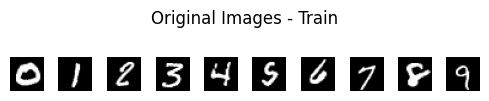

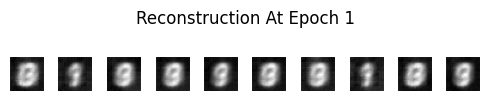

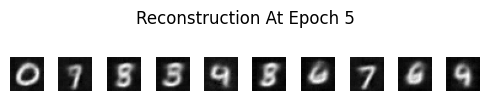

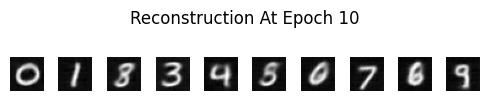

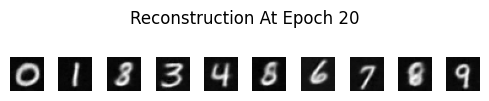

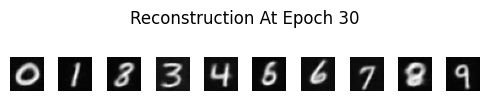

In [ ]:
amortized_reconstruct_plot(train_dataset, "Train")

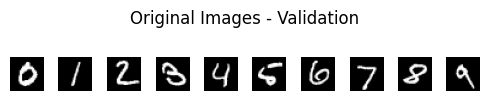

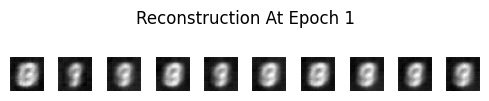

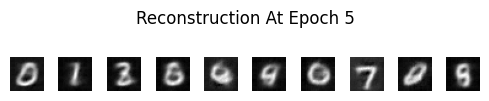

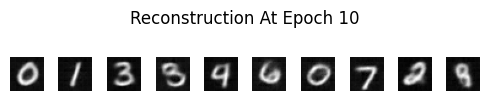

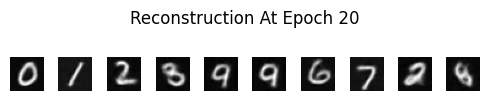

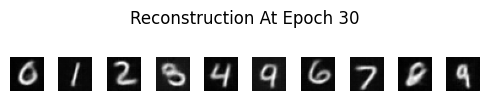

In [ ]:
amortized_reconstruct_plot(test_dataset, "Validation")

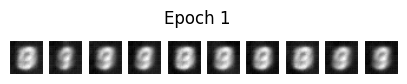

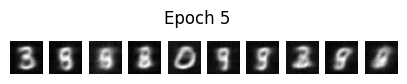

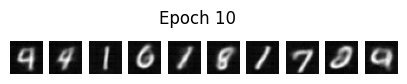

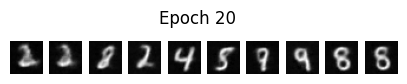

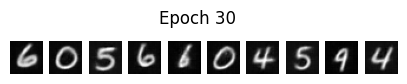

In [ ]:
samples_from_amortized_vae()

In [ ]:
class LatentOptimization(nn.Module):
  # Latent Optimization Module, reuses alot of code from the amortized model
  def __init__(self, n_samples, latent_dim=200):
    super().__init__()
    self.latent_dim = latent_dim
    self.mu = nn.Parameter(torch.randn(n_samples, latent_dim))
    self.logvar = nn.Parameter(torch.randn(n_samples, latent_dim))
    self.fc_decode = nn.Linear(latent_dim, 128)

    # Decoder
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(128, 128, kernel_size=2),  # (batch_size, 128, 2, 2)
      nn.ReLU(),
      nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 128, 4, 4)
      nn.ReLU(),
      nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # (batch_size, 64, 7, 7)
      nn.ReLU(),
      nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 32, 14, 14)
      nn.ReLU(),
      nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 1, 28, 28)
    )

  def reparameterize(self, mu, logvar):
    sigma = torch.exp(0.5*logvar)
    epsilon = torch.randn_like(sigma)
    return mu + sigma * epsilon

  def decode(self, z):
    z = self.fc_decode(z)
    z = z.view(z.size(0), 128, 1, 1)
    z = self.decoder(z)
    return z

  def forward(self, ind):
    z = self.reparameterize(self.mu[ind], self.logvar[ind])
    return self.decode(z), self.mu[ind], self.logvar[ind]

In [ ]:
# for the latent optimization since it needs the index of the images
class DatasetWithIndex(Dataset):
  def __init__(self, dataset):
    super().__init__()
    self.dataset = dataset

  def __getitem__(self,ind):
    image, label = self.dataset[ind]
    return image, label, ind

  def __len__(self):
    return len(self.dataset)

In [ ]:
# reusing some code from the amortized case
def train_epoch_latent_opt(model, dataloader, optimizer):
  # similar to the function for amortized vae, helper for train_latent_opt_VAE
  model.train()
  total_loss = 0.0
  total_x = 0
  mse_criterion = torch.nn.MSELoss(reduction='mean')
  for x,_,ind in tqdm(dataloader):
      x = x.to(device)
      optimizer.zero_grad()
      recon_x, mu, logvar = model(ind)

      # calculate loss as described in the exercise file(mse+kl)
      kl = (0.5*(torch.pow(mu, 2) + torch.exp(logvar) - logvar - 1)).mean()
      mse = mse_criterion(recon_x, x)
      loss = mse + kl
      # back to the normal training loop
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      total_x += 1
  return total_loss / total_x

In [ ]:
# reusing some code from the amortized case
train_dataset_with_index = DatasetWithIndex(train_dataset)
train_loader_with_index = DataLoader(train_dataset_with_index, batch_size=64, shuffle=False)

def train_latent_opt_VAE():
  # trains latent optimizer
  amortized_vae = ConvVAE(latent_dimension).to(device)
  model = LatentOptimization(len(train_dataset_with_index), latent_dimension).to(device)
  optim = optimizer([{'params': model.fc_decode.parameters(), 'lr': learning_rate},
                     {'params': model.decoder.parameters(), 'lr': learning_rate},
                    {'params': [model.mu, model.logvar], 'lr': learning_rate * 10}])
  # as specified in the exercise 0.01 lr for the latent vectors - optimizer syntax help from chatgpt
  losses = []
  for i in range(1, epochs + 1):
    losses.append(train_epoch_latent_opt(model, train_loader_with_index, optim))
    if i in reconst_epochs:
      # save the trained models for later use
      state_dict = model.state_dict()
      torch.save(state_dict, f'latent_opt_vae_{i}.tar')

  return losses

losses = train_latent_opt_VAE()

100%|██████████| 313/313 [00:07<00:00, 41.02it/s]


In [ ]:
# reusing some code from the amortized case
def get_class_samples_with_index(dataset):
  # returns a tensor of indexes as well as the samples for latent opt usage
  samples = [None for i in range(10)]
  indexes = [None for i in range(10)]
  classes_seen = set()
  for image, label, index in dataset:
    if label not in classes_seen:
      samples[label] = image.unsqueeze(0)
      indexes[label] = index
      classes_seen.add(label)
    if len(classes_seen) == 10:
      break
  return torch.cat(samples, dim=0), torch.tensor(indexes)

In [ ]:
# reusing some code from the amortized case
def latent_reconstruct_plot(dataset):
  # plot image reconstructions for the latent optimizer for each reconst_epoch
  images, indexes = get_class_samples_with_index(dataset)
  fig, axs = plt.subplots(1, 10, figsize=(5, 1))
  for i in range(10):
    axs[i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axs[i].axis('off')
  fig.suptitle(f'Original Images - Train')
  plt.tight_layout()
  for i in range(len(reconst_epochs)):
    state_dict = torch.load(f'latent_opt_vae_{reconst_epochs[i]}.tar')
    new_model = LatentOptimization(len(dataset), latent_dimension).to(device)
    new_model.load_state_dict(state_dict)
    new_model.eval()
    reconst_plot_epoch(new_model, reconst_epochs[i], indexes)

In [ ]:
# reusing some code from the amortized case
def samples_from_latent_vae():
  # sample 10 images from latent opt prior for each of reconst_epoch
  for i in range(len(reconst_epochs)):
    state_dict = torch.load(f'latent_opt_vae_{reconst_epochs[i]}.tar')
    new_model = LatentOptimization(len(train_dataset_with_index), latent_dimension).to(device)
    new_model.load_state_dict(state_dict)
    new_model.eval()
    fig, axs = plt.subplots(1, 10, figsize=(5, 1))
    fig.suptitle(f'Epoch {reconst_epochs[i]}')
    samples = sample_from_prior(new_model)
    for j in range(10):
      axs[j].imshow(samples[j].squeeze(), cmap='gray')
      axs[j].axis('off')

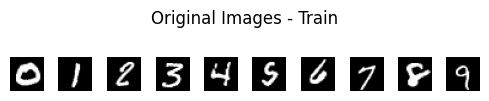

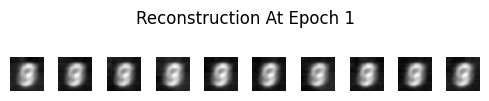

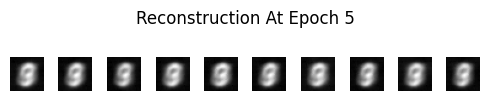

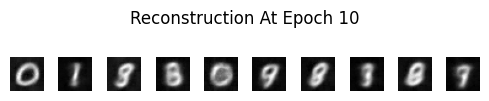

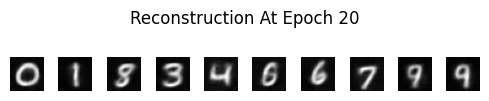

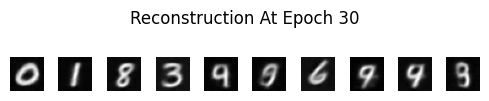

In [ ]:
latent_reconstruct_plot(train_dataset_with_index)

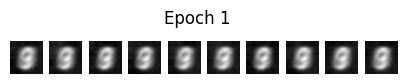

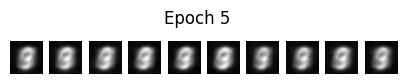

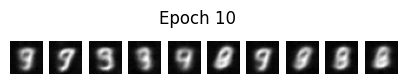

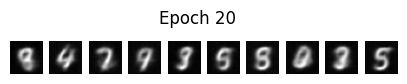

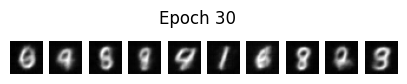

In [ ]:
samples_from_latent_vae()

In [ ]:
def plot_mnist_images_with_probs(images, probs):
  # plot given images and their log probabilities
  fig, axes = plt.subplots(2, 5, figsize=(15, 6))
  axes = axes.flatten()

  for i in range(10):
      ax = axes[i]
      ax.imshow(images[i].cpu().squeeze(), cmap='gray')
      ax.axis('off')
      ax.set_title(f"Log Probability: {probs[i].item():.2f}")
  plt.tight_layout()
  plt.show()

In [ ]:
def get_log_prob(model, image):
  # calculates log probability of image(x) with Eq. 9 for given model
  num_samples = 1000 # M=1000
  image = image.unsqueeze(0)
  image = image.to(device)
  mu, logvar = model.encode(image)
  mu, logvar = mu.squeeze(0), logvar.squeeze(0)
  std = torch.exp(0.5 * logvar)

  eps = torch.randn((num_samples, model.latent_dim), device=device)
  z_samples = mu.unsqueeze(0) + eps * std.unsqueeze(0)

  # p(z)
  log_pz = -0.5 * (z_samples ** 2 + torch.log(torch.tensor(2 * torch.pi, device=device))).sum(dim=1)

  # q(z|x)
  log_qzx = -0.5 * (((z_samples - mu.unsqueeze(0)) ** 2) /
    (std.unsqueeze(0) ** 2) + logvar.unsqueeze(0) + torch.log(
        torch.tensor(2 * torch.pi, device=device))).sum(dim=1)

  # p(x|z)
  decoded = model.decode(z_samples)
  image = image.expand_as(decoded)
  recon_loss = ((decoded - image) ** 2).view(num_samples, -1).sum(dim=1)

  log_pxz = - recon_loss / (2 * posterior_var**2) - (
      torch.log(torch.tensor(2 * torch.pi * posterior_var**2, device=device)) *
    image[0].numel() / 2)

  inner = log_pz + log_pxz - log_qzx
  log_px = torch.logsumexp(inner, dim=0) - torch.log(torch.tensor(num_samples, device=device))

  return log_px.item()



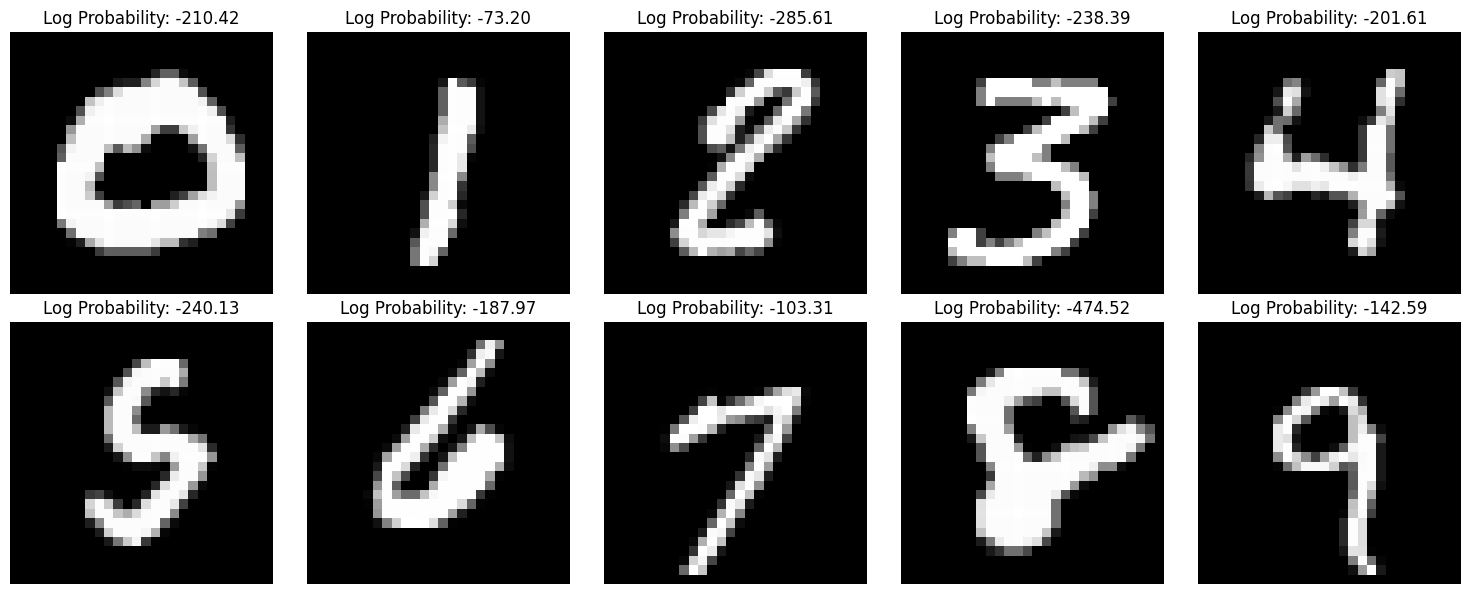

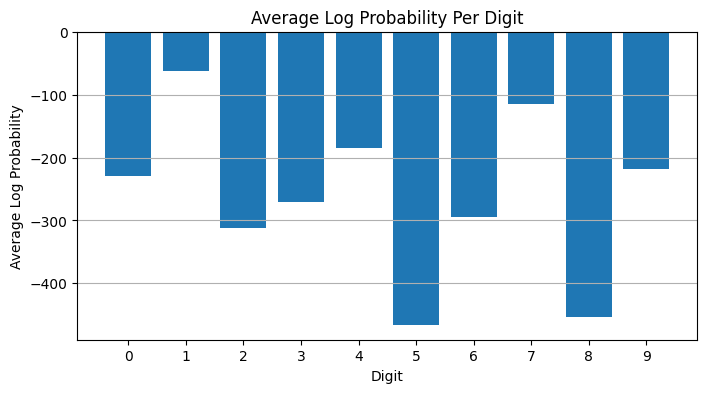

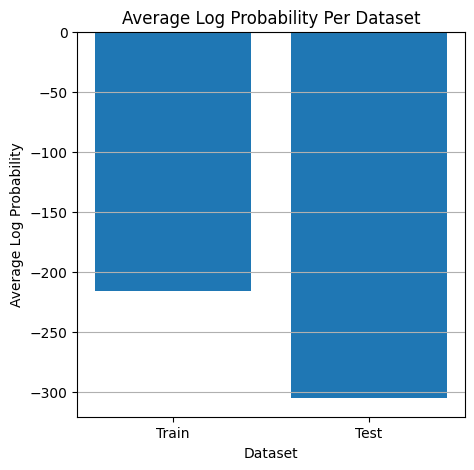

In [ ]:
def log_prob_samples():
  # Q4- calculate log probabilities of images from train and test and plot
  # them and lot probability averages
  image_arrs = []
  ind_arrs = []
  state_dict = torch.load(f'amortized_vae_30.tar')
  model = ConvVAE(latent_dimension).to(device)
  model.load_state_dict(state_dict)
  model.eval()
  for dataset in [train_dataset, test_dataset]:
    for i in range(5):
      image_arrs.append(get_class_samples(dataset))
  probs = torch.zeros(10,10)
  for i in range(10):
    for j in range(10):
      probs[i][j] = get_log_prob(model, image_arrs[i][j])
  plot_mnist_images_with_probs(image_arrs[0], probs[0])

  # plotting the avarage log probabilities
  avg_probs = probs.mean(dim=0)
  plt.figure(figsize=(8, 4))
  plt.bar(torch.arange(10), avg_probs)
  plt.xlabel('Digit')
  plt.ylabel('Average Log Probability')
  plt.title('Average Log Probability Per Digit')
  plt.xticks(torch.arange(10))
  plt.grid(True, axis='y')
  plt.show()

  # average log probability by set
  avg_train = probs[:5].mean()
  avg_test = probs[5:].mean()
  plt.figure(figsize=(5, 5))
  plt.bar(["Train", "Test"], [avg_train, avg_test])
  plt.xlabel('Dataset')
  plt.ylabel('Average Log Probability')
  plt.title('Average Log Probability Per Dataset')
  plt.grid(True, axis='y')
  plt.show()
log_prob_samples()